In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch 
import torch.optim as optim
from torch.utils.data import Dataset, Subset
from torch.utils.data import random_split
from PIL import Image
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import time

In [17]:
transformation = transforms.Compose( [transforms.Resize((32,32)), 
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                          std=[0.5, 0.5, 0.5])])

#change average sizes
#grabbing dataset
dataset = torchvision.datasets.ImageFolder('dataset', 
                                                transform=transformation)

#randomly splitting for training and testing
training_set, testing_set = random_split(dataset, [2328, 998])


                                                
train_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=100, shuffle=True, num_workers=2)

In [3]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.linear(x)
        return x

model = LogisticRegression(input_size=3072, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(30):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.view(-1, 3072)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/100], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 3072)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test set: {100 * correct / total} %')

Accuracy of the model on the test set: 33.366733466933866 %


In [18]:
#building neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
        self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(8 * 8 * 64, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10)
    )
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [14]:
num_epochs = 12
num_classes = 10
learning_rate = 0.001

In [19]:
#initializing CNN
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

In [20]:
start = time.perf_counter()
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
        (correct / total) * 100))
end = time.perf_counter()
print(f"{round(end-start,2)} seconds")

Epoch [1/12], Step [24/24], Loss: 1.6923, Accuracy: 32.14%
Epoch [2/12], Step [24/24], Loss: 1.4991, Accuracy: 39.29%
Epoch [3/12], Step [24/24], Loss: 1.4314, Accuracy: 42.86%
Epoch [4/12], Step [24/24], Loss: 1.4482, Accuracy: 46.43%
Epoch [5/12], Step [24/24], Loss: 1.1786, Accuracy: 46.43%
Epoch [6/12], Step [24/24], Loss: 1.4994, Accuracy: 35.71%
Epoch [7/12], Step [24/24], Loss: 0.9573, Accuracy: 64.29%
Epoch [8/12], Step [24/24], Loss: 0.7983, Accuracy: 67.86%
Epoch [9/12], Step [24/24], Loss: 0.7799, Accuracy: 71.43%
Epoch [10/12], Step [24/24], Loss: 0.8495, Accuracy: 71.43%
Epoch [11/12], Step [24/24], Loss: 0.8046, Accuracy: 75.00%
Epoch [12/12], Step [24/24], Loss: 0.9407, Accuracy: 57.14%
156.27 seconds


In [21]:
#Saving Model
torch.save(model.state_dict(), 'models/finalModel.pt')

In [22]:
#testing the model after it has beeen trained
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the 1000 test images: {:.2f}%'
          .format((correct / total) * 100))

Test Accuracy of the model on the 1000 test images: 59.00%
Test Accuracy of the model on the 1000 test images: 58.50%
Test Accuracy of the model on the 1000 test images: 59.67%
Test Accuracy of the model on the 1000 test images: 58.25%
Test Accuracy of the model on the 1000 test images: 59.20%
Test Accuracy of the model on the 1000 test images: 57.83%
Test Accuracy of the model on the 1000 test images: 56.14%
Test Accuracy of the model on the 1000 test images: 56.00%
Test Accuracy of the model on the 1000 test images: 57.11%
Test Accuracy of the model on the 1000 test images: 57.62%


Time to evaluate our data.
First will be the training data.


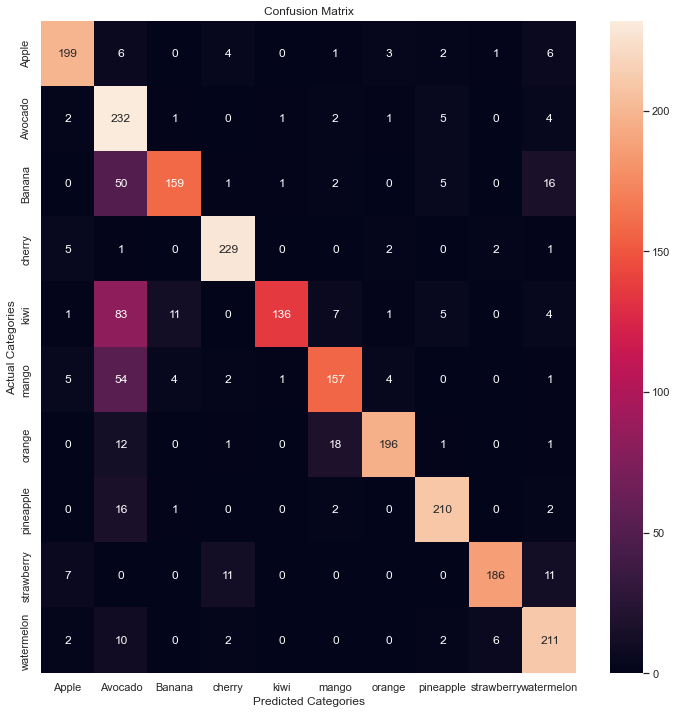

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       221
           1       0.94      0.50      0.65       464
           2       0.68      0.90      0.78       176
           3       0.95      0.92      0.93       250
           4       0.55      0.98      0.70       139
           5       0.69      0.83      0.75       189
           6       0.86      0.95      0.90       207
           7       0.91      0.91      0.91       230
           8       0.87      0.95      0.91       195
           9       0.91      0.82      0.86       257

    accuracy                           0.82      2328
   macro avg       0.82      0.87      0.83      2328
weighted avg       0.85      0.82      0.82      2328



In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

print("Time to evaluate our data.")
print("First will be the training data.")

#building Confusion Matrix as well as getting accuracy, predictions and F1 score for train model
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())
        
sns.set(rc={'figure.figsize':(12,12)})
confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g' )
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])
confusionMatrix.yaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])


plt.show()

#printing Accuracy, Prediction and F1 score for training model
print(classification_report(prediction_list, accurate_list))

Now to evaluate the testing data.


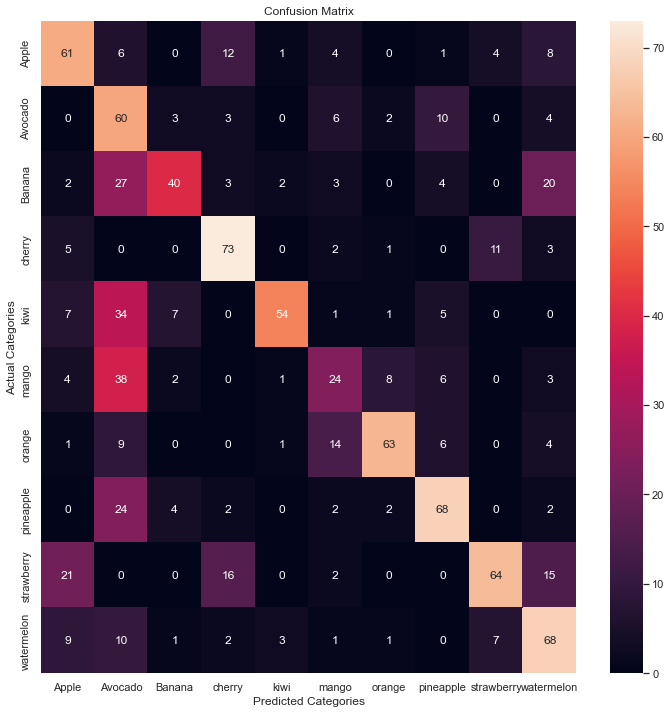

              precision    recall  f1-score   support

           0       0.63      0.55      0.59       110
           1       0.68      0.29      0.41       208
           2       0.40      0.70      0.51        57
           3       0.77      0.66      0.71       111
           4       0.50      0.87      0.63        62
           5       0.28      0.41      0.33        59
           6       0.64      0.81      0.72        78
           7       0.65      0.68      0.67       100
           8       0.54      0.74      0.63        86
           9       0.67      0.54      0.59       127

    accuracy                           0.58       998
   macro avg       0.58      0.62      0.58       998
weighted avg       0.61      0.58      0.57       998



In [24]:
#building Confusion Matrix as well as getting accuracy, predictions and F1 score for test model

print("Now to evaluate the testing data.")
model.eval()
prediction_list = []
accurate_list = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(model(images), 1)
        prediction_list.extend(predicted.detach().cpu().numpy())
        accurate_list.extend(labels.detach().cpu().numpy())

sns.set(rc={'figure.figsize':(12,12)})

confusion_matrix_data = confusion_matrix(accurate_list, prediction_list)
confusionMatrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g')
confusionMatrix.set_title('Confusion Matrix');
confusionMatrix.set_xlabel('Predicted Categories')
confusionMatrix.set_ylabel('Actual Categories');
confusionMatrix.xaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])
confusionMatrix.yaxis.set_ticklabels(['Apple','Avocado','Banana','cherry','kiwi','mango','orange','pineapple','strawberry','watermelon'])

  
plt.show()

#printing Accuracy, Prediction and F1 score for testing model
print(classification_report(prediction_list, accurate_list))

In [26]:
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

full_dataset = torchvision.datasets.ImageFolder('dataset', 
                                                transform=transformation)

full_loader=torch.utils.data.DataLoader(full_dataset, batch_size=1000, shuffle=True, num_workers=2)

kfold = KFold(n_splits=10, shuffle=True, random_state=None)
fold_value = 1
for training_id, testing_id in kfold.split(dataset):
   
    print("Fold Number:", fold_value)
    training_dataset = Subset(dataset, training_id)
    testing_dataset = Subset(dataset, testing_id)
    train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=1000, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=1000, shuffle=True, num_workers=2)
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 10
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Train accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
            .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
            (correct / total) * 100))
    model.eval()
    prediction_list = []
    accurate_list = []
    with torch.no_grad():
        for images, labels in full_loader:
            outputs = model(images)
            _, predicted = torch.max(model(images), 1)
            prediction_list.extend(predicted.detach().cpu().numpy())
            accurate_list.extend(labels.detach().cpu().numpy())
    print(classification_report(prediction_list, accurate_list))
    fold_value+=1

Fold Number: 1
Epoch [1/10], Step [3/3], Loss: 2.8469, Accuracy: 15.51%
Epoch [2/10], Step [3/3], Loss: 2.0024, Accuracy: 27.90%
Epoch [3/10], Step [3/3], Loss: 1.8006, Accuracy: 30.61%
Epoch [4/10], Step [3/3], Loss: 1.6315, Accuracy: 38.47%
Epoch [5/10], Step [3/3], Loss: 1.5530, Accuracy: 42.20%
Epoch [6/10], Step [3/3], Loss: 1.5011, Accuracy: 45.92%
Epoch [7/10], Step [3/3], Loss: 1.3432, Accuracy: 46.22%
Epoch [8/10], Step [3/3], Loss: 1.3291, Accuracy: 50.25%
Epoch [9/10], Step [3/3], Loss: 1.2609, Accuracy: 53.68%
Epoch [10/10], Step [3/3], Loss: 1.2074, Accuracy: 55.39%
              precision    recall  f1-score   support

           0       0.34      0.60      0.43       179
           1       0.50      0.40      0.45       417
           2       0.60      0.41      0.48       498
           3       0.49      0.80      0.61       203
           4       0.81      0.40      0.54       715
           5       0.32      0.45      0.38       229
           6       0.55      0.82  

Epoch [3/10], Step [3/3], Loss: 1.7137, Accuracy: 35.61%
Epoch [4/10], Step [3/3], Loss: 1.5898, Accuracy: 41.95%
Epoch [5/10], Step [3/3], Loss: 1.5088, Accuracy: 40.34%
Epoch [6/10], Step [3/3], Loss: 1.4273, Accuracy: 45.17%
Epoch [7/10], Step [3/3], Loss: 1.3468, Accuracy: 50.20%
Epoch [8/10], Step [3/3], Loss: 1.3046, Accuracy: 52.82%
Epoch [9/10], Step [3/3], Loss: 1.2053, Accuracy: 56.64%
Epoch [10/10], Step [3/3], Loss: 1.1837, Accuracy: 55.94%
              precision    recall  f1-score   support

           0       0.17      0.50      0.25       108
           1       0.47      0.49      0.48       321
           2       0.17      0.63      0.26        89
           3       0.28      0.94      0.44       101
           4       0.87      0.34      0.49       905
           5       0.21      0.50      0.30       133
           6       0.71      0.61      0.66       380
           7       0.69      0.48      0.57       475
           8       0.31      0.40      0.35       257
  